# Word Embeddings

In this session we will make use of Word2Vec to learn distributed representations of words based on the context within which they appear in sentences. 

## Learning word embeddings

We'll first try to learn word embeddings using the Word2Vec implementation provided by the gensim package. 
- Information on gensim's word2vec implementation is available here: https://radimrehurek.com/gensim/models/word2vec.html
- First install the package using pip:

In [1]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will build a Word2Vec embedding using the 20 Newsgroup data:

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
dataset_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In order to train Word2Vec on the data we first need to convert it to the right format. 
- For training Word2Vec, it is usual to **separate data into individual sentences** and then tokenize those sentences separately
- So let's use regular expressions to remove the end-of-line characters from each document and then split the documents into sentences using a regular expression that looks for question marks, exclamation marks, and periods, followed by a space: 

In [3]:
import re

# remove newline characters
docs = [re.sub('\n', ' ', doc) for doc in dataset_train.data]
# remove email addresses
docs = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', doc) for doc in docs]
# split sentences 
sentences = [re.split('[?!.]\s', doc) for doc in docs]
sentences[:3]

[['I was wondering if anyone out there could enlighten me on this car I saw the other day',
  'It was a 2-door sports car, looked to be from the late 60s/ early 70s',
  'It was called a Bricklin',
  'The doors were really small',
  'In addition, the front bumper was separate from the rest of the body',
  'This is  all I know',
  'If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail.'],
 ['A fair number of brave souls who upgraded their SI clock oscillator have shared their experiences for this poll',
  'Please send a brief message detailing your experiences with the procedure',
  'Top speed attained, CPU rated speed, add on cards and adapters, heat sinks, hour of usage per day, floppy disk functionality with 800 and 1.4 m floppies are especially requested',
  " I will be summarizing in the next two days, so please add to the network knowledge base if you have done the cl

Above, we've printed out the first two documents, which have been split into arrays of sentences. 
- We'll need to flatten the structure into one big array of sentences (remove the distinction between documents) before providing it to Word2Vec. 
- We can do that using the flatten command from the pandas library:

In [4]:
from pandas.core.common import flatten

sentences = list(flatten(sentences))
sentences[:20]

['I was wondering if anyone out there could enlighten me on this car I saw the other day',
 'It was a 2-door sports car, looked to be from the late 60s/ early 70s',
 'It was called a Bricklin',
 'The doors were really small',
 'In addition, the front bumper was separate from the rest of the body',
 'This is  all I know',
 'If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail.',
 'A fair number of brave souls who upgraded their SI clock oscillator have shared their experiences for this poll',
 'Please send a brief message detailing your experiences with the procedure',
 'Top speed attained, CPU rated speed, add on cards and adapters, heat sinks, hour of usage per day, floppy disk functionality with 800 and 1.4 m floppies are especially requested',
 " I will be summarizing in the next two days, so please add to the network knowledge base if you have done the clock upgrade 

Now we can proceed to do some cleaning of the data: 
- remove non-letter characters from each sentence 
- lowercase 
- tokenize the sentences based on whitespace
- remove any sentence with length less than 2 since it won't be useful for training Word2Vec. 

In [5]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day']
['it', 'was', 'a', '2', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', 'early', '70s']
['it', 'was', 'called', 'a', 'bricklin']
['the', 'doors', 'were', 'really', 'small']
['in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body']
['this', 'is', 'all', 'i', 'know']
['if', 'anyone', 'can', 'tellme', 'a', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'e', 'mail']
['a', 'fair', 'number', 'of', 'brave', 'souls', 'who', 'upgraded', 'their', 'si', 'clock', 'oscillator', 'have', 'shared', 'their', 'experiences', 'for', 'this', 'poll']
['please', 'send', 'a', 'brief', 'message', 'detailing', 'your', 'experiences', 'with

Finally we have the data in the right format for training Word2Vec, so we can provide it to the algorithm. For parameters, we set: 
- the embedding size to be 30,
- the minimum count for any vocabulary term to be 5
- the size of the context window to 10.

In [6]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

Let's see how big the vocabulary is that Word2Vec ended up using, i.e. how many word vectors did it learn:

In [7]:
len(model.wv)

22069

## Inspecting embeddings and finding similar words

Now that we have a word2vec model trained, what can we do with it?
- Let's print out one of the vectors to see what it looks like:

In [8]:
term = 'car'
model.wv[term]

array([-1.0530041e+00, -1.4519714e+00,  1.1528670e+00, -1.4847744e+00,
        2.6206491e+00,  5.3028929e-01, -1.3036146e+00, -1.0517687e+00,
       -3.9041209e-01, -1.8180987e+00,  7.7447164e-01,  2.6382170e+00,
        2.3791687e+00,  6.2678295e-01,  6.2672371e-01, -1.6133331e+00,
        1.6807460e+00,  1.1270120e+00,  3.7053999e-02, -1.9957888e+00,
        1.9591078e+00,  1.2932129e+00,  9.8793232e-04,  8.8042873e-01,
       -1.3427997e+00,  2.2153776e+00,  2.0970497e+00, -1.6210202e+00,
        3.1352274e+00,  2.4653795e+00], dtype=float32)

Unlike LDA's document topic vector, this one has both positive and negative values.

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space.
- Try modifying the terms below to see what their closest neighbouring terms are: 
  - Some good terms to try are: hockey, mouse, god, microsoft, clinton, bush, etc.
  - (If yuo see an error, that is because the term you chose is not in the dictionary.)

In [9]:
# term = 'gun'
# term = 'microsoft'
term ='clinton'

model.wv.most_similar(term)

[('administration', 0.8793745040893555),
 ('president', 0.8793587684631348),
 ('initiative', 0.7889375686645508),
 ('official', 0.7782489657402039),
 ('bush', 0.7762735486030579),
 ('stimulus', 0.7604988217353821),
 ('bill', 0.7461441159248352),
 ('policy', 0.7421618700027466),
 ('senior', 0.7251121401786804),
 ('congress', 0.7102846503257751)]

Do the similar terms agree with your intuition?

## Visualising the embedding vectors using t-SNE

We'll now visualise some of the word vectors in a 3 dimensional space using t-SNE.

The vocabulary of word vectors is quite large (around 25,000). Giving them all to t-SNE will cause it to take far too long to converge.
- So let's first choose a random subset of 500 terms to show:

In [10]:
import random

sample = random.sample(list(model.wv.key_to_index), 500)
print(sample)

['x_s6', 'rapes', 'drill', 'sudden', 'contradictions', 'sky', 'treasurer', 'critiques', 'postmaster', 'exclusive', 'author', 'noring', 'account', 'mvi', 'wb', 'pursuing', 'havent', '139', 'saturation', 'ff', 'bombers', 'hmmmm', 'austrian', 'berube', 'misfortune', 'house', '346', 'hayward', '720k', 'trantor', 'discrimination', 'remedy', 'culture', 'gca', 'paranoia', 'eradicate', 'vue', 'possessed', 'dill', '186', 'feature', 'sevres', 'ever', 'mw3p', 'summit', 'syphilis', 'adcom', 'nato', 'emphasis', '15555l', 'enclosure', 'blinker', 'nls', 'popes', 'harbor', 'judging', 'castle', 'ritual', 'ellison', 'programmer', '191', 'era', 'screwing', 'lau', 'yields', 'pistons', 'lenstra', 'pram', 'rf', 'root', 'rm', 'presidential', '71t', 'hasn', 'fixed', 'masonry', 'indicates', 'asleep', 'l9', 'viking', 'receiving', 'market', 'glyphs', 'barbarism', 'coil', 'bn', 'embarrassing', 'willis', 'lesser', 'mind', 'jpl', '8900', 'bp', 'rft', 'sf', 'sigkids', 'fortran', '429', 'abilities', 'ncsu', '320x200x

Now we'll get the word vectors for the sampled terms:

In [11]:
word_vectors = model.wv[sample]
word_vectors

array([[-0.02253545, -0.3547414 ,  0.15083297, ...,  0.27531222,
        -0.00074998, -0.26276004],
       [-0.06091135, -0.07019429,  0.05042991, ...,  0.088785  ,
         0.12540908, -0.25499904],
       [-0.2344886 , -0.4339343 ,  0.12171444, ...,  0.14110357,
         0.05755936, -0.08692578],
       ...,
       [ 0.03205361, -0.2689286 ,  0.21948983, ...,  0.09293395,
         0.1421836 , -0.12703507],
       [-0.349997  , -0.17110416,  0.17578408, ...,  0.31098   ,
         0.07880431, -0.62742096],
       [ 0.01792586, -0.07568579,  0.1182115 , ...,  0.01056102,
         0.05534219, -0.07294247]], dtype=float32)

And we'll provide the vectors to TSNE to fit a model and transform the data to 3 dimensions:

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

Now transform the data into 3 columns (for x, y, and z):

In [13]:
import numpy as np

x, y, z = np.transpose(tsne_embedding)

And generate the 3d plot:

In [14]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import plotly.express as px

fig = px.scatter_3d(x=x, y=y, z=z)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

Well that's a not a particularly interesting 3d plot! 
- How about we label some of the points on the graph to see what words they correspond to:

In [16]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Let's extend the random set of terms with a set of colours to see if they cluster:

In [17]:
# Add some specific terms to sample:
colours = ['red','green','blue','orange','yellow','purple','pink','cream','brown','black','white','gray']

word_vectors = model.wv[colours+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [18]:
import plotly.express as px

r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Note: t-SNE is a stochastic algorithm, so run it a couple of times to see how the visualisation changes.

Have a play around with the visualisation to see whether other sets of terms cluster together.

## Loading Pre-trained Embedding

Instead of learning your own word embeddings from a dataset, it is common to download and make use of pre-trained embeddings that have been learnt on very large corpora. 
- See this list of models available in gensim: https://github.com/RaRe-Technologies/gensim-data
- Note how big some of the models are. A 300 dimensional Word2Vec model trained on Google News (word2vec-google-news-300) is almost 1.7GB!

Let's downlaod a couple of the smaller models and have a look at them: 
- We'll download two GloVe (similar to Word2Vec) based models
- each has dimension of 50, but the first has been trained on data from Twitter and the second on data from Wikipedia

In [19]:
import gensim.downloader as api

model_twitter = api.load("glove-twitter-50")
model_wiki = api.load("glove-wiki-gigaword-50")

[================================================--] 96.6% 192.7/199.5MB downloaded
[==================================================] 100.0% 66.0/66.0MB downloaded


How big are their vocabularies?

In [20]:
print(f"Vocabulary size twitter model:   {len(model_twitter)}")
print(f"Vocabulary size wikipedia model: {len(model_wiki)}")

Vocabulary size twitter model:   1193514
Vocabulary size wikipedia model: 400000


Woah, they are big vocabularies! 
- The twitter one has over a million tokens!

Let's have a look at the most similar terms to the word 'puppy' in Twitter embedding:

In [21]:
term = 'puppy'
print(f'Twitter embedding, most similar words to: {term}')
model_twitter.most_similar(term)

Twitter embedding, most similar words to: puppy


[('kitten', 0.9134266972541809),
 ('dog', 0.8790459632873535),
 ('puppies', 0.8616614937782288),
 ('doggy', 0.8477217555046082),
 ('pug', 0.8410165905952454),
 ('bear', 0.8376337885856628),
 ('cat', 0.833551287651062),
 ('kitty', 0.8321102857589722),
 ('pup', 0.8269115686416626),
 ('husky', 0.8156434297561646)]

And in the Wikipedia embedding:

In [22]:
print(f'Wikipedia embedding, most similar words to: {term}')
model_wiki.most_similar(term)

Wikipedia embedding, most similar words to: puppy


[('puppies', 0.8058912754058838),
 ('dog', 0.7754921913146973),
 ('goat', 0.7691047787666321),
 ('cat', 0.7625599503517151),
 ('kitten', 0.7443127036094666),
 ('retriever', 0.731249988079071),
 ('rottweiler', 0.724050760269165),
 ('rabbit', 0.7144317626953125),
 ('squirrel', 0.7086658477783203),
 ('bitch', 0.7056955695152283)]

Which embedding is better? 

Try some other words:

In [23]:
# term = 'apple'
term = 'politecnico'
print(f'Twitter embedding:   {model_twitter.most_similar(term)}')
print(f'Wikipedia embedding: {model_wiki.most_similar(term)}')

Twitter embedding:   [('jalisciense', 0.7551587224006653), ('politécnico', 0.7421476244926453), ('velodromo', 0.7381073236465454), ('externado', 0.7372220754623413), ('calasanz', 0.7361232042312622), ('maristas', 0.7354950308799744), ('atletic', 0.7325177788734436), ('champagnat', 0.7301465272903442), ('dominico', 0.7282001972198486), ('maquinista', 0.7259823679924011)]
Wikipedia embedding: [('milano', 0.780189037322998), ('certosa', 0.762841522693634), ('triennale', 0.7528361678123474), ('genova', 0.7016634941101074), ('pavia', 0.6901755332946777), ('mantova', 0.680837869644165), ('gubbio', 0.6743451356887817), ('firenze', 0.6713487505912781), ('pratica', 0.6634273529052734), ('baler', 0.6576954126358032)]


Embedding spaces have interesting geometric properties, where translation between different word vectors caries semantic meaning. 
- Let's try running the famous analogy: king + (woman - man) = ?
- To do that, first generate the resulting word embedding:

In [24]:
vec = model_wiki.get_vector('king') + (model_wiki.get_vector('woman') - model_wiki.get_vector('man'))  
vec

array([ 0.41736597,  0.90427005, -1.0050299 , -0.06202101,  0.4972599 ,
        0.80667007, -0.14855   ,  0.80365   , -0.15654   , -0.66973996,
        0.23435399,  0.62476003,  0.925871  , -0.97099996,  0.92566   ,
        0.89915   , -1.54596   , -0.52625   ,  0.13695401,  0.66199005,
        0.48716003,  0.37035006, -0.214214  ,  0.10100999,  0.71358   ,
       -2.0874999 , -1.1362001 , -1.14961   , -0.53599   ,  0.27389997,
        1.6723    ,  0.02931   , -0.77656007,  0.46056286,  0.34866   ,
       -0.05741701,  0.19444   , -0.207748  , -0.73038995, -0.10752001,
        0.23554398,  0.96423995, -0.46994   , -0.48727497, -0.25399995,
        0.46212995, -0.66081   , -1.9451499 , -0.68797004, -0.49784002],
      dtype=float32)

- Then look for the most similar vectors to it: 

In [25]:
model_wiki.similar_by_vector(vec)

[('king', 0.8859834671020508),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634970545768738),
 ('princess', 0.7512727975845337),
 ('elizabeth', 0.7506489157676697),
 ('father', 0.7314497232437134),
 ('kingdom', 0.7296158671379089),
 ('mother', 0.728001058101654)]

Did it work? 
- Well, yes if you remove 'king' as an option, then it did!
- Note that the most similar vector to the word 'king' was not 'queen' but 'prince', so the analogy is indeed changing the order ...

In [26]:
model_wiki.most_similar('king')

[('prince', 0.8236179351806641),
 ('queen', 0.7839043140411377),
 ('ii', 0.7746230363845825),
 ('emperor', 0.7736247777938843),
 ('son', 0.766719400882721),
 ('uncle', 0.7627150416374207),
 ('kingdom', 0.7542160749435425),
 ('throne', 0.7539913654327393),
 ('brother', 0.7492411136627197),
 ('ruler', 0.7434253692626953)]

Try it again but with the Twitter based model

In [27]:
model = model_twitter
vec = model.get_vector('king') + (model.get_vector('woman') - model.get_vector('man')) 
model.similar_by_vector(vec)

[('stone', 0.7156722545623779),
 ('woman', 0.7105387449264526),
 ('meets', 0.7078651189804077),
 ('queen', 0.7035095691680908),
 ('king', 0.7032954692840576),
 ('royal', 0.7007310390472412),
 ('african', 0.6984354853630066),
 ('prince', 0.6961740851402283),
 ('virgin', 0.6757708787918091),
 ('american', 0.6597097516059875)]

Doesn't seem that the Twitter model is as good on that analogy. 
- If you think about the average quality of text on Twitter versus Wikipedia, then that's probably not suprising!

Try some other analogies:
- What happens to Rome if we subtract Italy and add France?

In [28]:
A = 'rome'
B = 'italy'
C = 'france'
C = 'indonesia'
model = model_wiki
vec = model.get_vector(A) - model.get_vector(B) + model.get_vector(C) 
model.similar_by_vector(vec)

[('jakarta', 0.7579053640365601),
 ('myanmar', 0.7317277789115906),
 ('indonesia', 0.7256942391395569),
 ('yangon', 0.7137079238891602),
 ('manila', 0.7006157040596008),
 ('cambodia', 0.6926183104515076),
 ('bangkok', 0.6885415315628052),
 ('tibet', 0.676415741443634),
 ('delhi', 0.6711347103118896),
 ('philippines', 0.6673232316970825)]

Now, **isn't that cool?** ;-)
- Try some other countries ...

Remember, we are only using the 'small' embeddings of 50 dimensions 
- you can download and try the bigger ones, some of them with 300 dimensions


## Classifying Tweets with word embeddings

Let's try to use the word embeddings as features for a text classifier. 
- In particular, we'll try the tweet sentiment analysis task from the second session.
- First download the dataset:

In [29]:
import nltk

nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

Then prepare the dataset: 
- load the positive and negative tweets
- remove emoticons from them
- and merge them into a single dataset with class labels

In [30]:
from nltk.corpus import twitter_samples

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

import re 

emoticon_regex = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'
positive_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in positive_tweets]
negative_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in negative_tweets]

tweets_x = positive_tweets_noemoticons + negative_tweets_noemoticons
tweets_y = ['positive']*len(positive_tweets) + ['negative']*len(negative_tweets)

Divide the data into train, validation and test sets:

In [31]:
from sklearn.model_selection import train_test_split

temp_x, test_x, temp_y, test_y = train_test_split(tweets_x, tweets_y, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

Now we need to convert the tweets to an embedding representation. 
- We can do that by computing the sum (or average) of the embedding vectors of the words in the tweet.
- To work out how to do that, let's have a look at the first tweet in the dataset, converting it to lowercase and tokenise it on whitespace:

In [32]:
import string
import re
regex = '[' + string.punctuation + ']'

print('tweet: \'' + train_x[10] + '\'')
tokens = re.sub(regex, '', train_x[10].lower()).split()
print('tokens: ', tokens)

tweet: '@antichankai yup!! i always order there anyways 😂 i hope it pushes through :(('
tokens:  ['antichankai', 'yup', 'i', 'always', 'order', 'there', 'anyways', '😂', 'i', 'hope', 'it', 'pushes', 'through']


- We can get the embedding vectors for the tokens present in the embedding vocabulary as follows: 

In [33]:
model = model_twitter
embeddings = [model.get_vector(token) for token in tokens if token in model]
embeddings

[array([ 0.84084 ,  0.38576 ,  0.44391 , -0.29588 , -0.21162 ,  0.58388 ,
         1.1472  ,  0.31473 ,  0.47395 ,  1.4195  , -0.033755,  0.11669 ,
        -2.8464  , -0.019387, -0.26455 ,  0.49833 ,  0.55217 , -0.36789 ,
        -0.94789 ,  0.11284 , -0.25014 , -0.25167 ,  0.015115,  0.22507 ,
        -0.051181,  0.51332 , -0.16374 , -0.63544 ,  0.89011 , -0.63056 ,
        -0.27888 ,  0.85639 , -0.20034 , -0.35561 , -0.58959 ,  0.086922,
        -0.16893 ,  0.14267 ,  0.35541 ,  0.12951 , -0.48847 ,  0.13318 ,
         0.69356 ,  0.47781 , -0.26982 , -0.3265  ,  0.40061 , -0.13289 ,
        -0.31796 ,  0.45475 ], dtype=float32),
 array([-0.043148,  0.50393 ,  0.27095 , -0.1198  , -0.58991 , -0.32774 ,
         0.15549 , -0.5465  ,  0.4169  ,  1.5267  , -0.48707 , -0.095806,
        -5.9675  ,  0.12915 , -0.48301 , -0.14715 ,  0.12052 , -0.19595 ,
        -0.86387 , -0.17507 ,  0.4924  ,  0.38274 ,  0.2987  ,  0.13115 ,
        -0.13744 , -0.20918 ,  0.10783 , -0.10709 ,  0.41345 ,  0

- the sum of the embeddings in the tweet is:

In [34]:
sum(embeddings)

array([  0.82424957,   2.5608668 ,   1.4533019 ,  -0.16128887,
        -1.6069942 ,   3.2105029 ,   8.87241   ,  -0.2579791 ,
         2.7265358 ,   5.46413   ,   0.10667402,  -0.68599397,
       -51.6113    ,  -1.553728  ,  -4.510344  ,   1.8966072 ,
         0.61843187,  -2.581407  ,  -4.9078193 ,  -2.8208125 ,
         2.060097  ,  -0.06939106,   0.09625402,   4.76756   ,
        -1.00092   ,   5.5226393 ,   1.8329202 ,  -0.818313  ,
         3.520465  ,  -1.0601919 ,  -2.61499   ,   4.153611  ,
         0.88802093,  -0.4973309 ,   1.9439979 ,   2.8123534 ,
         0.34633097,   2.72018   ,   1.596538  ,   3.2370799 ,
        -6.474718  ,   3.0297298 ,   3.848698  ,  -0.16079006,
         1.5604689 ,  -2.18328   ,   2.93243   ,  -2.3513691 ,
        -1.709298  ,   1.6767061 ], dtype=float32)

- and the average of the embeddings is just:

In [35]:
import numpy as np

np.mean(embeddings, axis=0)

array([ 0.07493178,  0.23280607,  0.13211836, -0.01466262, -0.14609037,
        0.2918639 ,  0.8065827 , -0.02345265,  0.24786688,  0.4967391 ,
        0.00969764, -0.06236309, -4.6919365 , -0.141248  , -0.4100313 ,
        0.17241883,  0.05622108, -0.23467337, -0.44616538, -0.2564375 ,
        0.18728155, -0.00630828,  0.00875037,  0.43341455, -0.09099273,
        0.5020581 ,  0.1666291 , -0.07439209,  0.32004225, -0.09638108,
       -0.23772636,  0.37760103,  0.08072918, -0.0452119 ,  0.17672707,
        0.2556685 ,  0.03148463,  0.24728909,  0.14513981,  0.29428   ,
       -0.5886107 ,  0.27543   ,  0.34988162, -0.01461728,  0.14186081,
       -0.19848   ,  0.26658455, -0.21376084, -0.15539072,  0.15242782],
      dtype=float32)

We will need to perform this vector transformation for all tweets in the training and also the test sets
- We can define a procedure to do that for us

In [36]:
import numpy as np

def vectorize(docs, embedding_model=model_twitter, useSum=True):
    vectors = np.zeros((len(docs),50))
    for i in range(len(docs)):
        tokens = re.sub(regex, '', docs[i].lower()).split()
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

Let's now vectorize the training set
- and then print out one of the instances to check that the format is correct:

In [37]:
train_x_vector = vectorize(train_x)
train_x_vector[:3]

array([[ 1.74442005e+00,  2.05451012e+00,  5.25519013e-01,
        -1.34068990e+00, -1.54917109e+00,  1.06829584e-01,
         2.81574988e+00,  1.99108005e+00,  1.90934992e+00,
         3.61858988e+00, -8.98380041e-01,  1.72530997e+00,
        -1.82348003e+01, -2.41696000e+00, -1.20666099e+00,
         9.67240036e-02,  2.91375965e-01, -1.52586699e+00,
        -3.77273011e+00, -8.96431923e-01,  6.26724958e-01,
         5.46789944e-01,  2.02252960e+00,  1.87739992e+00,
        -2.96952993e-01,  1.27346468e+00, -5.63426018e-01,
        -1.28230989e+00, -1.38962293e+00, -1.64652014e+00,
        -3.31034994e+00,  1.30696988e+00, -7.66076684e-01,
        -1.32262111e-01, -2.55102992e+00,  1.74556994e+00,
        -1.65197992e+00, -4.72635031e-01,  2.47862995e-01,
         4.85584021e-01, -2.74821997e+00,  1.31376100e+00,
         1.44179296e+00,  2.16038990e+00, -9.85478997e-01,
        -5.94025016e-01,  3.29648995e+00,  1.88759005e+00,
        -1.46899009e+00,  2.09504008e+00],
       [ 3.21

Now that we have the vectorized training data, we can go ahead and train the model!

In [38]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000).fit(train_x_vector, train_y)
print(lr_model)

LogisticRegression(max_iter=1000)


Let's test the model on the example tweets from the second tutorial:

In [39]:
tweets = []
tweets.append('I can\'t believe how much fun I\'m having learning to train a text classifier using word embeddings!')
tweets.append('I am really confused. I want my mommy.')
tweets.append('The internet connection has been pretty annoying today!')
tweets.append('They just played my favourite song on the radio.')
tweets.append("I don't like going to the dentist.")
tweets.append("Can't wait for my three hour math class tomorrow morning. Yay!")


transformed_tweets = vectorize(tweets)
predictions = lr_model.predict(transformed_tweets)
predicted_probabilities = lr_model.predict_proba(transformed_tweets)

for i in range(len(tweets)):
  print(f'tweet:      {tweets[i]}')
  print(f'prediction: {predictions[i]}')
  print(f'confidence: {predicted_probabilities[i]}')
  print()

tweet:      I can't believe how much fun I'm having learning to train a text classifier using word embeddings!
prediction: positive
confidence: [0.48419569 0.51580431]

tweet:      I am really confused. I want my mommy.
prediction: negative
confidence: [0.84015978 0.15984022]

tweet:      The internet connection has been pretty annoying today!
prediction: negative
confidence: [0.83200169 0.16799831]

tweet:      They just played my favourite song on the radio.
prediction: positive
confidence: [0.47264555 0.52735445]

tweet:      I don't like going to the dentist.
prediction: negative
confidence: [0.85931145 0.14068855]

tweet:      Can't wait for my three hour math class tomorrow morning. Yay!
prediction: negative
confidence: [0.57025793 0.42974207]



We can have a look at the coefficients of the logistic regression classification model. 
- How many should there be?

In [40]:
lr_model.coef_

array([[-2.49267345e-03, -3.11921376e-03,  2.01335148e-02,
         5.43786407e-03,  1.72668347e-01,  2.19241720e-01,
         7.92841163e-02, -1.17684967e-01, -9.75576689e-02,
         3.48645522e-02, -1.04210579e-01,  2.61285865e-01,
         3.64533016e-02, -2.93392970e-02, -2.08853917e-01,
         3.36947104e-02, -2.59393432e-02,  1.11617083e-04,
         1.23033026e-01,  2.73951193e-02, -1.83948104e-02,
        -7.58558596e-02, -8.55650838e-02, -8.11626797e-02,
         7.41333091e-02,  5.65065496e-02,  9.65414249e-02,
        -2.40278356e-02,  1.67391664e-01,  8.38040583e-02,
         1.89417218e-01,  9.64813528e-02, -2.09475579e-02,
         4.05857312e-02,  1.45968680e-01,  1.99769828e-01,
         1.47105828e-01,  1.43058849e-01, -2.25103969e-02,
        -4.54303357e-02, -5.11516178e-02, -7.18676200e-02,
         3.20119661e-02,  1.46172307e-01, -6.75508238e-03,
         7.18303533e-02,  3.38256236e-02, -2.93742090e-02,
         5.46694233e-05, -3.91859868e-02]])

Let's vectorize the validaton data and see how well the embeddings-based classifier performs on it:

Accuracy: 0.718125


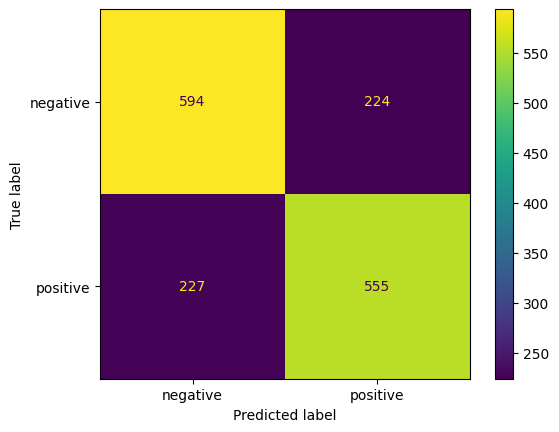

In [41]:
valid_x_vector = vectorize(valid_x)
pred_y = lr_model.predict(valid_x_vector)

from sklearn.metrics import accuracy_score

print(f'Accuracy: {accuracy_score(valid_y, pred_y)}')

import matplotlib.pyplot as plt  
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lr_model, valid_x_vector, valid_y, values_format='d')  
plt.show() 

So pretty much the same accuracy as the bag-of-words based classifier. 
- but this time with feature vectors of size 50
- what happens to the accuracy if we: 
  - use a different embedding: model_wiki instead of model_twitter
  - use a bigger (higher dimensional) embedding: download a larger one to see
  - use the average rather than the sum to generate the feature vector?
- try it out:

In [42]:
# TODO

Accuracy: 0.683125


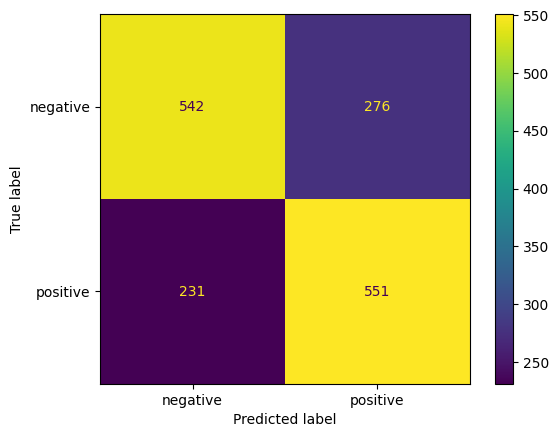

In [43]:
# Vecorise
train_x_vector = vectorize(train_x, embedding_model=model_wiki)
# Fit model
lr_model = LogisticRegression(max_iter=1000).fit(train_x_vector, train_y)
# Evaluate results
valid_x_vector = vectorize(valid_x, embedding_model=model_wiki)
pred_y = lr_model.predict(valid_x_vector)

print(f'Accuracy: {accuracy_score(valid_y, pred_y)}')

ConfusionMatrixDisplay.from_estimator(lr_model, valid_x_vector, valid_y, values_format='d')  
plt.show() 

Accuracy: 0.679375


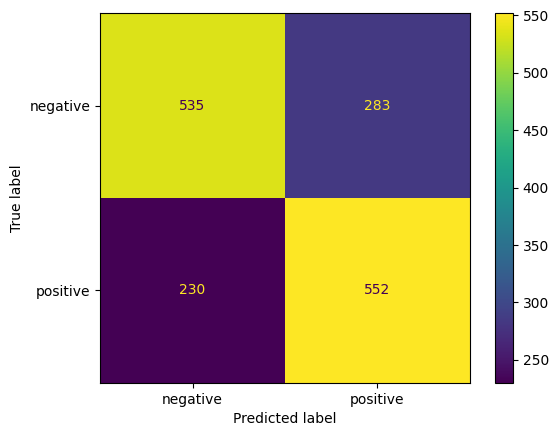

In [44]:
# Vecorise
train_x_vector = vectorize(train_x, embedding_model=model_wiki, useSum=False)
# Fit model
lr_model = LogisticRegression(max_iter=1000).fit(train_x_vector, train_y)
# Evaluate results
valid_x_vector = vectorize(valid_x, embedding_model=model_wiki, useSum=False)
pred_y = lr_model.predict(valid_x_vector)

print(f'Accuracy: {accuracy_score(valid_y, pred_y)}')

ConfusionMatrixDisplay.from_estimator(lr_model, valid_x_vector, valid_y, values_format='d')  
plt.show() 

Accuracy: 0.728125


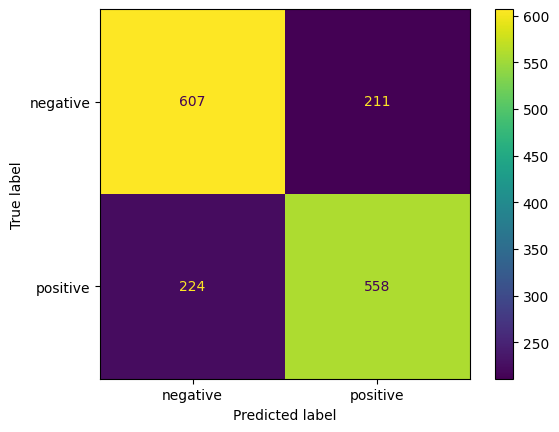

In [45]:
# Vecorise
train_x_vector = vectorize(train_x, useSum=False)
# Fit model
lr_model = LogisticRegression(max_iter=1000).fit(train_x_vector, train_y)
# Evaluate results
valid_x_vector = vectorize(valid_x, useSum=False)
pred_y = lr_model.predict(valid_x_vector)

print(f'Accuracy: {accuracy_score(valid_y, pred_y)}')

ConfusionMatrixDisplay.from_estimator(lr_model, valid_x_vector, valid_y, values_format='d')  
plt.show() 

Also worth trying is doc2vec rather than word2vec embeddings:
- in theory they should give slightly better performance on sentence classification tasks
- see here: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

## Other uses for Word2Vec embeddings

Have a look at this inventive post that learns Word2Vec embeddings for automobiles described in CSV file:
- https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
- The embeddings allow for similarity computations across  the vehicles. 


In [46]:
# TODO

## FastText (sub-word) embeddings

Try training a fasttext model:

https://pypi.org/project/fasttext/

You can have a look at the API and documentation at this [link](https://fasttext.cc).

Let's start by installing the fastText package.
(Note that, alterantively, Genism has a specific API for fastText that wraps the package we are going to use)

In [47]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395551 sha256=8bce956b2180a18e1c9e1556f194181eed03eb7bf027c783d4ed0199b7e5c515
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


Now that we have installed the package, we can download one of the pre-trained models (you can find here the list of available models)

In [48]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
!wget http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gzip -d cc.en.300.bin.gz

--2023-03-31 07:57:39--  http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.13, 18.154.144.87, 18.154.144.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.13|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   152MB/s    in 29s     

2023-03-31 07:58:08 (149 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



Finally we can create a model istance:

In [49]:
import fasttext

ft_model = fasttext.load_model('./cc.en.300.bin')

What is the size of the vocabulary?

In [50]:
len(ft_model.get_words())

2000000

What is the size of the embeddings?

In [51]:
ft_model.get_dimension()

300

How do we get the embedding of a word?

In [52]:
ft_model.get_word_vector('car')

array([ 1.37498349e-01,  1.73652887e-01,  1.55173652e-02,  2.37601340e-01,
       -2.04669774e-01,  1.87128603e-01,  2.91468382e-01,  3.73304449e-03,
        4.89513204e-02,  2.60247648e-01, -8.31757560e-02, -1.56491295e-01,
        8.69184956e-02, -4.78181392e-02, -1.18615523e-01,  1.54884279e-01,
       -1.69153258e-01, -1.22394666e-01, -1.40723094e-01,  4.53762040e-02,
       -3.81604545e-02, -1.46799475e-01,  1.36863321e-01, -1.50539711e-01,
       -1.81618929e-02,  1.47275031e-02, -4.21417244e-02,  1.39445990e-01,
        4.28556725e-02,  3.05333138e-01, -1.66591443e-02,  2.91614503e-01,
       -3.32667604e-02, -4.68752086e-02,  2.67606732e-02,  8.71477500e-02,
       -5.38966954e-02,  1.33774459e-01,  8.50976482e-02, -6.40801638e-02,
       -1.03779674e-01, -1.81272849e-01, -1.10902652e-01,  1.66989714e-01,
       -1.99763715e-01,  4.53899801e-03, -1.89182535e-02, -2.78699417e-02,
       -2.93243110e-01, -5.81464916e-03,  1.75295904e-01,  1.08659819e-01,
       -1.88145787e-02,  

Alterantively you can use it as a Python dictionary

In [53]:
ft_model['man']  

array([ 2.05102742e-01, -1.17439777e-01, -1.55425537e-02,  1.79349303e-01,
       -2.28049219e-01, -1.24558017e-01,  1.23250902e-01,  5.38473055e-02,
        4.11795303e-02, -5.67295495e-03, -8.39752406e-02,  1.84653439e-02,
       -8.60689804e-02,  1.12930965e-02, -1.33117482e-01,  1.38373390e-01,
       -1.25412792e-01, -3.86665910e-02, -1.22192718e-01,  1.07491598e-01,
        7.44868889e-02,  1.43000856e-01, -2.68281717e-02,  7.85946473e-03,
       -3.62306088e-02, -2.08035931e-02,  9.95780062e-03, -5.96441068e-02,
        3.78727615e-02,  1.31439894e-01, -6.71993792e-02,  6.71701431e-02,
        1.11701377e-01, -1.82819627e-02, -1.02341630e-01,  9.74911451e-03,
        4.25241441e-02, -1.59083098e-01,  3.72390151e-02, -1.32961005e-01,
       -6.62351400e-02,  1.17778786e-01, -3.11643854e-02, -4.58469465e-02,
       -1.54904723e-01,  2.37882137e-03,  2.09096503e-02, -6.17710687e-03,
       -2.41204053e-01,  8.73834118e-02,  6.91391528e-02,  1.11958645e-01,
       -1.52415112e-02, -

Now we can test a bit the capabilities of fastText (examples are taken from [here](https://fasttext.cc/docs/en/unsupervised-tutorial.html)).

A base functionality is to search for close vectors in the embedding space

In [54]:
word = 'asparagus'

ft_model.get_nearest_neighbors(word)

[(0.7746413350105286, 'aspargus'),
 (0.7368614077568054, 'Asparagus'),
 (0.7233701944351196, 'broccoli'),
 (0.7113494873046875, 'broccolini'),
 (0.7106742262840271, 'leeks'),
 (0.7096290588378906, 'artichokes'),
 (0.7028921842575073, 'asparagas'),
 (0.6759673953056335, 'kohlrabi'),
 (0.6757089495658875, 'radishes'),
 (0.6669561862945557, 'spinach')]

The first search takes additional time because the model is doing some sort of indexing in the embedding space. fastText uses a tool called FAISS to speed up the search in the embedding space (https://github.com/facebookresearch/faiss)

We can also solve analogies directly, without doing the computations by hand

In [55]:
# ft_model.get_analogies("man", "woman", "king")
ft_model.get_analogies("psx", "sony", "nintendo")

[(0.7647636532783508, 'snes'),
 (0.7282403707504272, 'gamecube'),
 (0.7111096382141113, 'n64'),
 (0.6962550282478333, 'gba'),
 (0.6485379338264465, 'dreamcast'),
 (0.6467888951301575, 'ps2'),
 (0.6442886590957642, 'SNES'),
 (0.6383660435676575, 'zelda'),
 (0.6379032135009766, 'Snes'),
 (0.6377424001693726, 'famicom')]

Note that we are dealing with a model using also subword n-grams, so we can get the representation and the similarity even of out of vocabulary words

For example we can search for the word **confuzzling** (which is an actual real fake word https://en.wiktionary.org/wiki/confuzzling):

In [56]:
word = "confuzzling"
print(f'Word {word} is in the fastText model vocabulary? {word in ft_model}')
for s, w in ft_model.get_nearest_neighbors(word):
    print(f'{s}: {w}')

Word confuzzling is in the fastText model vocabulary? False
0.613641083240509: confuzzled
0.550931990146637: Confuzzled
0.4055270850658417: confuddled
0.3816613256931305: confusing
0.36328595876693726: confused
0.36032891273498535: nondescriptive
0.359388530254364: Wikipedia-Page-Suzannah-B-Troy-6-yrs-after-Misogynist-Cyber-Vandalism-Censorship-via-Deletion-on-a-page-about-Censorship-Wikipedia-Agrees-to-retur
0.3525550067424774: muddly
0.3524904251098633: official-like
0.3516576588153839: unflattering.Coordinating


This is why character n-grams are so important

We can also encode a sentence (sequence of tokens) into a single vector

In [57]:
sent = ft_model.get_sentence_vector("Hello, is it me you're looking for? I can see it in your eyes. I can see it in your smile.")
sent

array([ 9.72567871e-03, -1.81693081e-02,  1.98467262e-02,  3.74992117e-02,
       -3.59138474e-02, -4.57771569e-02, -2.72532683e-02,  1.52418101e-02,
        3.52445617e-02, -7.53624178e-03,  9.12996754e-03, -2.10552160e-02,
        1.56272377e-03, -9.82039783e-05, -8.77684914e-03,  3.65382321e-02,
        3.64734158e-02, -7.05009839e-03, -2.33118087e-02,  6.08711829e-03,
       -1.99545734e-02,  1.54522238e-02,  6.07244065e-03, -8.34608357e-03,
       -3.15462463e-02, -9.89805069e-03, -5.55238919e-04, -6.88232016e-03,
       -1.15120355e-02,  1.13332726e-01,  2.06005611e-02, -1.42829418e-02,
       -4.10122750e-03, -1.72664113e-02,  3.63585819e-03, -1.34615647e-02,
       -4.80954209e-03,  4.18015793e-02, -8.03579669e-03, -5.55655640e-03,
       -3.50303599e-03,  5.23055904e-03, -2.29117647e-02,  2.92630084e-02,
        2.04842985e-02,  3.14234160e-02,  2.69671367e-03,  4.90053743e-02,
        1.12765245e-02,  4.62619215e-03,  5.81054529e-03, -1.93861313e-02,
        2.83782464e-03, -

(Maybe this can be useful to train a classifier for the twitter sentiment analysis...)

What if we want to train a model on our own (maybe with smaller embeddings)?
You can find a quick reference to the API [here](https://fasttext.cc/docs/en/python-module.html)

To train a model we need to convert the data set into the appropriate format, a text file containing al the samples we have.
We can start from the sentences we have from before

In [58]:
with open('./data.txt', 'w') as f:
    f.write('\n'.join(sentences))

We can even choose whether to use a Skipgram based approach:

In [ ]:
ft_skip_model = fasttext.train_unsupervised('data.txt', model='skipgram', dim=30, minCount=5, ws=10)

Or a Continuos Bag-of-Words (CBoW) approach:

In [ ]:
ft_cbow_model = fasttext.train_unsupervised('data.txt', model='cbow')

Try to do the same visualisation we tried before, see how the same words are placed in a downprojection of the representation space.

In [ ]:
# TODO